# Lemon Data Challenge - Resolución

## Consigna:

#### 1) Calcular Churn Rate / Retención de Usuarios
#### 2) Calcular Average Revenue Per User
#### 3) Calcular Lifetime Value (LTV)


### Limpieza de datasets

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# READ DATASETS 
d_rates = pd.read_csv('rates.csv')
d_transactions = pd.read_csv('transactions.csv')
d_user = pd.read_csv('users.csv')

In [3]:
d_transactions

,id,user_id,amount,state,operation_type,transaction_type,currency,createdat
0,00024dce-8d40-4ae8-9e28-558213a3e311,3222205,100.020000,DONE,CREDIT,CRYPTO_SALE,MONEY,2022-03-03T14:36:05
1,002da6df-ab3d-46ab-a5a8-c52ef7e9c91e,1058316,1060.000000,DONE,DEBIT,LEMON_CARD_PAYMENT,MONEY,2022-03-20T22:17:37
2,0035b8cf-d08e-4a3a-8a0b-a8be619f75df,3245984,349.270000,DONE,CREDIT,CRYPTO_SALE,MONEY,2022-01-21T06:10:52
3,0078c4a7-83ec-4a77-a811-700fa6f6b2b1,4430720,1440.000000,DONE,DEBIT,LEMON_CARD_PAYMENT,MONEY,2022-03-16T12:52:18
4,0085edff-1129-424a-9a0f-7190547e9c72,3193610,100.000000,DONE,DEBIT,CRYPTO_PURCHASE,MONEY,2022-02-10T19:22:23
...,...,...,...,...,...,...,...,...
8831,9829149a-4470-4393-8e71-57662ab2c7b6,5102251,0.000828,DONE,CREDIT,CRYPTO_PURCHASE,BTC,2022-04-08T04:25:15
8832,6234ab81-c661-4c13-a218-1dd7110b5a73,6017291,500.000000,DONE,DEBIT,CRYPTO_PURCHASE,MONEY,2022-04-08T11:48:30
8833,1b147496-e8a8-4cd9-b37e-6c4025d6d6e3,5492949,340.000000,DONE,DEBIT,LEMON_CARD_PAYMENT,MONEY,2022-04-08T12:28:46
8834,f95e5f7e-d70f-4a12-917b-60a10ff3e81e,5775889,9700.000000,DONE,CREDIT,VIRTUAL_DEPOSIT,MONEY,2022-04-08T13:17:15


#### Cambios a realizar en los dataset

1. Formato de fecha string en datasets de users y transactions: Cambiar a datetime64 para permitir manipulación de datos. 
2. Assumption de Currency: Asumo que "MONEY" son transacciones en ARS y que el TIPO DE CAMBIO ARS/USD == $200.
3. Crear columnas de valor transaccionado en USD y de revenue asociado con cada transacción en caso de aplicar.

In [4]:
# CHANGE DATE FORMAT FOR USERS AND TRANSACTIONS DATASETS

t_dates = []
for i, v in d_transactions.iterrows():
    str_date = v.values[7][:10]
    n_date = dt.datetime.strptime(str_date, '%Y-%m-%d')
    t_dates.append(n_date)
d_transactions['createdat'] = t_dates

d_dates = []
for i, v in d_user.iterrows():
    str_date = v.values[3][:10]
    n_date = dt.datetime.strptime(str_date, '%Y-%m-%d')
    d_dates.append(n_date)
d_user['createdat'] = d_dates

In [5]:
type(d_transactions['createdat'].values[0])

numpy.datetime64

### Conversión de valores de cryptos a USD para el cálculo del revenue

In [6]:
# CONVERT TO USD VALUES EVERY CRYPTO PRICE

d_rates.columns = ['currency', 'quote_currency', 'price']
especies = d_rates.currency.unique()
len_rates = len(d_rates)
curr_dist = d_transactions.groupby('currency')['id'].count().reset_index()

quotes = []
btc, eth = float(42670), float(3236.38)

for i, v in d_rates.iterrows():
    if (v.values[0] == 'UST'):
        if v.values[1] == 'USDT':
            val = float(v.values[2])
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'BTC':
            val = float(v.values[2] * btc)
            quotes.append([v.values[0], v.values[1], v.values[2], val])

    elif v.values[0] == 'SAND':
        if v.values[1] == 'BTC':
            val = v.values[2] * btc
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'USDT':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    elif v.values[0] == 'USDC':
        quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])
        quotes.append(['ARS', 'ARS', 1/200, 1/200])

    elif v.values[0] == 'UNI':
        if v.values[1] == 'BTC':
            val = v.values[2] * btc
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'USDT':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    elif v.values[0] == 'ADA':
        if v.values[1] == 'ETH':
            val = v.values[2] * eth
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'BTC':
            val = v.values[2] * btc
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'USDT':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])
        elif v.values[1] == 'USDC':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    elif v.values[0] == 'LUNA':
        if v.values[1] == 'ETH':
            val = v.values[2] * eth
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'BTC':
            val = v.values[2] * btc
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'USDT':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])
        elif v.values[1] == 'UST':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    elif v.values[0] == 'SOL':
        if v.values[1] == 'ETH':
            val = v.values[2] * eth
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'BTC':
            val = v.values[2] * btc
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'USDT':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])
        elif v.values[1] == 'USDC':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    elif v.values[0] == 'ETH':
        if v.values[1] == 'USDC':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])
        elif v.values[1] == 'BTC':
            val = v.values[2] * btc
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'USDT':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])
        elif v.values[1] == 'UST':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])
        elif v.values[1] == 'DAI':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    elif v.values[0] == 'SLP':
        if v.values[1] == 'ETH':
            val = v.values[2] * eth
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'USDT':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    elif (v.values[0] == 'DOT') or (v.values[0] == 'AXS') or (v.values[0] == 'MANA') or (v.values[0] == 'ALGO'):
        if v.values[1] == 'ETH':
            val = v.values[2] * eth
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'BTC':
            val = v.values[2] * btc
            quotes.append([v.values[0], v.values[1], v.values[2], val])
        elif v.values[1] == 'USDT':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    elif v.values[0] == 'USDT':
        if v.values[1] == 'DAI':
            quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

    else:
        quotes.append([v.values[0], v.values[1], v.values[2], v.values[2]])

new_rates = pd.DataFrame(quotes, columns=['currency', 'quote_curr', 'base_price', 'usd_price'])

In [7]:
new_rates

,currency,quote_curr,base_price,usd_price
0,UST,USDT,1.000000,1.000000
1,SAND,BTC,0.000069,2.963005
2,USDC,USDT,0.999800,0.999800
3,ARS,ARS,0.005000,0.005000
4,UNI,BTC,0.000230,9.835435
5,ADA,ETH,0.000323,1.046322
6,LUNA,ETH,0.029650,95.958667
7,SOL,ETH,0.034990,113.240936
8,SOL,BTC,0.002655,113.301651
9,SOL,USDT,113.310000,113.310000


In [8]:
# CONVERT TRANSACTION AMOUNTS TO FIT RATES DATASET

d_transactions.currency.replace('MONEY', 'ARS', inplace=True)
d_transactions.currency.replace('DAI', 'USDT', inplace=True)

curr_dist = d_transactions.groupby('currency')['id'].count().reset_index()
curr_dist.sort_values('currency', inplace=True)

t_rates = new_rates[['currency', 'usd_price']]
t_rates.drop_duplicates(subset='currency', inplace=True)
curr_dist_rates = t_rates['currency'].drop_duplicates().reset_index(drop=True)
curr_dist_rates = pd.DataFrame(curr_dist_rates)
curr_dist_rates.sort_values('currency', inplace=True)

d_transactions.set_index('currency', inplace=True)
t_rates.set_index('currency', inplace=True)
d_transactions_dummy = d_transactions

t_comb = pd.merge(d_transactions, t_rates, left_index=True, right_index=True)
t_comb.reset_index(inplace=True)
t_comb['t_value_usd'] = t_comb['amount'] * t_comb['usd_price']
d_transactions = t_comb
d_transactions.sort_values('createdat', inplace=True)

<ipython-input-8-1264830cb5f7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_rates.drop_duplicates(subset='currency', inplace=True)


Dataset de transacciones ya tiene incorporado el valor en USD de la transacción para calcular revenue

In [9]:
d_transactions

,currency,id,user_id,amount,state,operation_type,transaction_type,createdat,usd_price,t_value_usd
3779,ARS,b6c2f6b0-8d7e-45ef-a566-3d5654133059,447286,47.080000,DONE,CREDIT,VIRTUAL_DEPOSIT,2021-08-30,0.005,0.235400
4352,ARS,d44b27e7-a613-4bbb-b803-8e75b3735de5,447286,47.080000,DONE,DEBIT,VIRTUAL_WITHDRAWAL,2021-09-07,0.005,0.235400
542,ARS,0ea7c76c-947a-4cdf-b88e-70fb38c456e6,526750,332.760000,DONE,CREDIT,CRYPTO_SALE,2021-09-10,0.005,1.663800
6747,BTC,6735471d-f63a-4c5c-ba75-d1b4ad0806bb,526750,0.000042,DONE,DEBIT,CRYPTO_SALE,2021-09-10,42663.010,1.790567
4358,ARS,d544aa0d-b7a4-4a93-a0dc-45e254257888,508389,295.590000,DONE,CREDIT,CRYPTO_SALE,2021-09-14,0.005,1.477950
...,...,...,...,...,...,...,...,...,...,...
6308,ARS,bcb521e4-6ff7-4ef6-b7e3-b768f270d6fe,3621933,200.000000,DONE,DEBIT,VIRTUAL_WITHDRAWAL,2022-04-08,0.005,1.000000
6309,ARS,7baef74c-2fc3-4c3d-8eb5-5cc95d0270c7,718788,1500.000000,DONE,CREDIT,VIRTUAL_DEPOSIT,2022-04-08,0.005,7.500000
6310,ARS,61a2c381-41c9-4e2e-93cd-a5c471ad77f5,3956344,2840.000000,DONE,DEBIT,LEMON_CARD_PAYMENT,2022-04-08,0.005,14.200000
6199,ARS,b414a83d-e317-4da9-9797-9fccd1276d97,5481511,460.000000,DONE,DEBIT,LEMON_CARD_PAYMENT,2022-04-08,0.005,2.300000


In [10]:
# CALCULATE LEMON'S REVENUE IN USD FOR EACH TYPE OF TRANSACTION

revenue = []

for i, v in d_transactions.iterrows():
    tran_type = v.values[6]
    status = v.values[4]
    if status == 'DONE':
        if tran_type == 'CRYPTO_SWAP':
            val_com = v.values[9] * 0.01
            revenue.append(val_com)
        elif (tran_type == 'CRYPTO_SALE') or (tran_type == 'CRYPTO_PURCHASE'):
            val_com = v.values[9] * 0.02
            revenue.append(val_com)
        elif (tran_type == 'LEMON_CARD_PAYMENT'):
            val_com = v.values[9] * 0.05
            revenue.append(val_com)
        else:
            val_com = 0
            revenue.append(val_com)
    else:
        val_com = 0
        revenue.append(val_com)

d_transactions['revenue'] = revenue


In [11]:
d_transactions

,currency,id,user_id,amount,state,operation_type,transaction_type,createdat,usd_price,t_value_usd,revenue
3779,ARS,b6c2f6b0-8d7e-45ef-a566-3d5654133059,447286,47.080000,DONE,CREDIT,VIRTUAL_DEPOSIT,2021-08-30,0.005,0.235400,0.000000
4352,ARS,d44b27e7-a613-4bbb-b803-8e75b3735de5,447286,47.080000,DONE,DEBIT,VIRTUAL_WITHDRAWAL,2021-09-07,0.005,0.235400,0.000000
542,ARS,0ea7c76c-947a-4cdf-b88e-70fb38c456e6,526750,332.760000,DONE,CREDIT,CRYPTO_SALE,2021-09-10,0.005,1.663800,0.033276
6747,BTC,6735471d-f63a-4c5c-ba75-d1b4ad0806bb,526750,0.000042,DONE,DEBIT,CRYPTO_SALE,2021-09-10,42663.010,1.790567,0.035811
4358,ARS,d544aa0d-b7a4-4a93-a0dc-45e254257888,508389,295.590000,DONE,CREDIT,CRYPTO_SALE,2021-09-14,0.005,1.477950,0.029559
...,...,...,...,...,...,...,...,...,...,...,...
6308,ARS,bcb521e4-6ff7-4ef6-b7e3-b768f270d6fe,3621933,200.000000,DONE,DEBIT,VIRTUAL_WITHDRAWAL,2022-04-08,0.005,1.000000,0.000000
6309,ARS,7baef74c-2fc3-4c3d-8eb5-5cc95d0270c7,718788,1500.000000,DONE,CREDIT,VIRTUAL_DEPOSIT,2022-04-08,0.005,7.500000,0.000000
6310,ARS,61a2c381-41c9-4e2e-93cd-a5c471ad77f5,3956344,2840.000000,DONE,DEBIT,LEMON_CARD_PAYMENT,2022-04-08,0.005,14.200000,0.710000
6199,ARS,b414a83d-e317-4da9-9797-9fccd1276d97,5481511,460.000000,DONE,DEBIT,LEMON_CARD_PAYMENT,2022-04-08,0.005,2.300000,0.115000


#### Armado de funciones para utilizar parcialmente el campo de fecha de transaccción y armar los cohortes de usuarios

In [12]:
def get_month(x):
    """
    Function that converts date format to year and month values
    """
    return dt.datetime(x.year, x.month, 1)

In [13]:
# CREATE COLUMN WITH SPECIFIC MONTHS TO GROUPBY DATAFRAME

d_transactions['tran_month'] = d_transactions['createdat'].apply(get_month)

In [14]:
# GROUPBY DATASET BY USER BASED ON MONTHLY ACTIVITY

t_grouping = d_transactions.groupby('user_id')['tran_month']

In [15]:
# SELECT THE EARLIEST DATE FOR EACH USER'S TRANSACTION

d_transactions['CohortMonth'] = t_grouping.transform('min')

In [53]:
d_transactions[['user_id', 'transaction_type', 'createdat', 't_value_usd', 'revenue', 'tran_month', 'CohortMonth']]

,user_id,transaction_type,createdat,t_value_usd,revenue,tran_month,CohortMonth
3779,447286,VIRTUAL_DEPOSIT,2021-08-30,0.235400,0.000000,2021-08-01,2021-08-01
4352,447286,VIRTUAL_WITHDRAWAL,2021-09-07,0.235400,0.000000,2021-09-01,2021-08-01
542,526750,CRYPTO_SALE,2021-09-10,1.663800,0.033276,2021-09-01,2021-09-01
6747,526750,CRYPTO_SALE,2021-09-10,1.790567,0.035811,2021-09-01,2021-09-01
4358,508389,CRYPTO_SALE,2021-09-14,1.477950,0.029559,2021-09-01,2021-09-01
...,...,...,...,...,...,...,...
6308,3621933,VIRTUAL_WITHDRAWAL,2022-04-08,1.000000,0.000000,2022-04-01,2022-02-01
6309,718788,VIRTUAL_DEPOSIT,2022-04-08,7.500000,0.000000,2022-04-01,2021-12-01
6310,3956344,LEMON_CARD_PAYMENT,2022-04-08,14.200000,0.710000,2022-04-01,2022-03-01
6199,5481511,LEMON_CARD_PAYMENT,2022-04-08,2.300000,0.115000,2022-04-01,2022-04-01


In [17]:
# CREATE FUNCTION THAT GETS INTEGER VALUES FOR DATETIME64 TYPE OF DATES

def get_date_int(df, column):
   year = df[column].dt.year
   month = df[column].dt.month
   return year, month

In [18]:
t_year, t_month = get_date_int(d_transactions, 'tran_month')

In [20]:
t_cohort_year, t_cohort_month = get_date_int(d_transactions, 'CohortMonth')

In [22]:
t_years_diff = t_year - t_cohort_year
t_months_diff = t_month - t_cohort_month

### Armado de Cohortes
Permiten analizar a los usuarios agrupandolos por un plazo de tiempo como una unidad comun en lugar de analizar individualmente a cada usuario.

#### Cálculo de un índice por cada cohorte de usuarios

In [24]:
d_transactions['CohortIndex'] = t_years_diff * 12 + t_months_diff + 1

In [25]:
t_grouping = d_transactions.groupby(['CohortMonth', 'CohortIndex'])

In [26]:
t_cohort_data = t_grouping['user_id'].apply(pd.Series.nunique).reset_index()

Agrupo el número de transacciones por usuario con el cohorte correspondiente

In [27]:
t_cohort_data

,CohortMonth,CohortIndex,user_id
0,2021-08-01,1,1
1,2021-08-01,2,1
2,2021-09-01,1,2
3,2021-09-01,2,1
4,2021-09-01,3,1
5,2021-09-01,5,1
6,2021-09-01,6,1
7,2021-09-01,7,1
8,2021-09-01,8,1
9,2021-10-01,1,7


#### Armado de tabla pivot que agrupa por mes y cohorte el número de transacciones realizado por cada usuario
Ejemplo: En el mes de agosto 2021 hubo una transacción (con o sin revenue asociado), realizadas por un usuario que al mes siguiente realizó otra transacción y luego dejó de operar con la plataforma.

In [28]:
# CREATE PIVOT TABLE

t_cohort_counts = t_cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='user_id')

In [29]:
t_cohort_counts

CohortIndex,1,2,3,4,5,6,7,8
CohortMonth,,,,,,,,
2021-08-01,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01,2.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0
2021-10-01,7.0,1.0,2.0,4.0,2.0,2.0,2.0,NaN
2021-11-01,26.0,12.0,12.0,9.0,14.0,7.0,NaN,NaN
2021-12-01,33.0,30.0,22.0,18.0,11.0,NaN,NaN,NaN
2022-01-01,60.0,44.0,31.0,19.0,NaN,NaN,NaN,NaN
2022-02-01,89.0,64.0,31.0,NaN,NaN,NaN,NaN,NaN
2022-03-01,126.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Obtención del número inicial de usuarios por cohorte que utilizaré como denominador del churn/retention rate.

In [30]:
# STORE COHORT ORIGINAL SIZE

t_cohort_sizes = t_cohort_counts.iloc[:,0]

In [31]:
t_cohort_sizes

CohortMonth
2021-08-01      1.0
2021-09-01      2.0
2021-10-01      7.0
2021-11-01     26.0
2021-12-01     33.0
2022-01-01     60.0
2022-02-01     89.0
2022-03-01    126.0
2022-04-01     36.0
Name: 1, dtype: float64

#### Cálculo de la tasa de retención de usuarios
La importancia de esta métrica radica en que permite graficar la continuidad del uso de la plataforma por parte de cada grupo de usuarios. Un alto grado de retención implica que los usuarios continúan usando la plataforma, otorgando mayor espacio para proyectar crecimiento y reduciendo el costo de adquisición por usuario.

In [32]:
t_retention = t_cohort_counts.divide(t_cohort_sizes, axis=0)*100

In [33]:
t_retention

CohortIndex,1,2,3,4,5,6,7,8
CohortMonth,,,,,,,,
2021-08-01,100.0,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01,100.0,50.000000,50.000000,NaN,50.000000,50.000000,50.000000,50.0
2021-10-01,100.0,14.285714,28.571429,57.142857,28.571429,28.571429,28.571429,NaN
2021-11-01,100.0,46.153846,46.153846,34.615385,53.846154,26.923077,NaN,NaN
2021-12-01,100.0,90.909091,66.666667,54.545455,33.333333,NaN,NaN,NaN
2022-01-01,100.0,73.333333,51.666667,31.666667,NaN,NaN,NaN,NaN
2022-02-01,100.0,71.910112,34.831461,NaN,NaN,NaN,NaN,NaN
2022-03-01,100.0,44.444444,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# CREATE A LIST OF MONTH NAMES TO PLOT HEATMAP (Y Axis)

t_month_list = t_retention.reset_index()['CohortMonth']

In [35]:
def get_month_name(x):
   return dt.datetime.strftime(x, '%b-%y')

t_month_list = t_month_list.apply(get_month_name)

In [36]:
t_month_list

0    Aug-21
1    Sep-21
2    Oct-21
3    Nov-21
4    Dec-21
5    Jan-22
6    Feb-22
7    Mar-22
8    Apr-22
Name: CohortMonth, dtype: object

### RESPUESTA PUNTO 1) - TASA DE RETENCION/CHURN

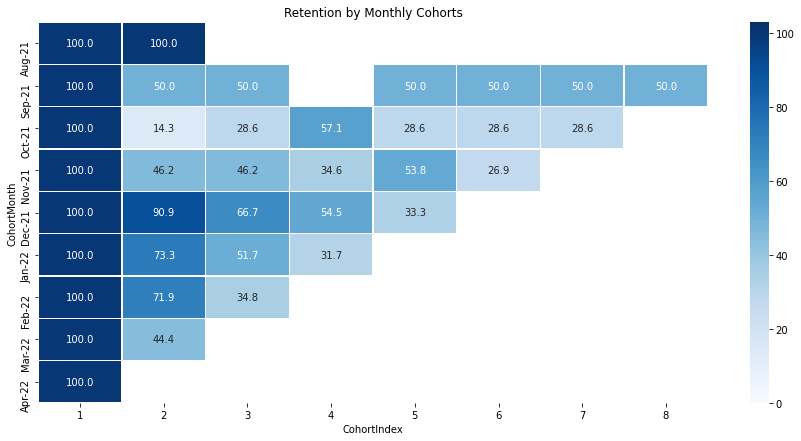

In [68]:
## PLOT HEAT MAP OF RETENTION RATE

plt.figure(figsize=(15,7))
plt.title('Retention by Monthly Cohorts')
# Create the heatmap
sns.heatmap(data=t_retention,
annot = True,
cmap = "Blues",
vmin = 0.0,
vmax = list(t_retention.max().sort_values(ascending = False))[1]+3,
fmt = '.1f',
linewidth = 0.3,
yticklabels=t_month_list)
plt.show()

**Explicación**: La mejor forma de analizar la tasa de retención es mediante un heatmap que agrupe por cohorte y mes la evolución del uso de la plataforma. 
- El primer grupo de usuarios, comenzado en agosto 2021, mantuvo actividades por un mes, dejando luego de utilizar la plataforma. 
- El segundo grupo mantuvo mayor constancia en el uso de la plataforma, logrando que el 50% de los usuarios continúe usando la plataforma hasta abril 2022 inclusive.
- El cohorte iniciado en octubre 2021 tuvo peor rendimiento en términos de retención ya que solo un 14% de los usuarios utilizó la plataforma luego del primer mes, si bien este número mejoró en meses posteriores al 28% de retención.
- Diciembre obtuvo los mejores registros, donde mas del 90% de los usuarios mantuvo el uso de la plataforma luego del primer mes y manteniendo un 66% y 54% los dos meses posteriores. 
- **En el largo plazo, la tasa de retención indicaría que el 30% de los usuarios continúa usando la plataforma.**

### RESPUESTA PUNTO 2) - REVENUE PROMEDIO POR USUARIO (ARPU)

In [37]:
# GROUP DATASET TO ANALIZE REVENUE PER USER

t_grouping = d_transactions.groupby(['CohortMonth', 'CohortIndex'])

In [40]:
# GROUP REVENUE BY COHORT INDEX

t_cohort_data = t_grouping['revenue'].sum()
t_cohort_data = t_cohort_data.reset_index()

#### A diferencia del punto anterior, agrupo por cohorte sumando el revenue obtenido por el uso de la plataforma.

In [41]:
t_cohort_data

,CohortMonth,CohortIndex,revenue
0,2021-08-01,1,0.000000
1,2021-08-01,2,0.000000
2,2021-09-01,1,0.130319
3,2021-09-01,2,0.000000
4,2021-09-01,3,0.000000
5,2021-09-01,5,0.000000
6,2021-09-01,6,0.000000
7,2021-09-01,7,0.389498
8,2021-09-01,8,0.000000
9,2021-10-01,1,50.816413


In [42]:
# PIVOT TABLE TO OBTAIN REVENUE PER USER AND COHORT

avg_rev = t_cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='revenue')
t_avg_rev = avg_rev.divide(t_cohort_sizes, axis=0)

In [43]:
t_avg_rev

CohortIndex,1,2,3,4,5,6,7,8
CohortMonth,,,,,,,,
2021-08-01,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01,0.065160,0.000000,0.000000,NaN,0.000000,0.000000,0.194749,0.0
2021-10-01,7.259488,0.000000,0.387397,5.717750,2.841770,3.332170,2.347879,NaN
2021-11-01,1.082020,1.251211,5.858222,2.836873,2.839170,0.200389,NaN,NaN
2021-12-01,3.183123,5.288564,4.118449,4.822761,0.887596,NaN,NaN,NaN
2022-01-01,4.747841,4.467846,1.591669,1.029610,NaN,NaN,NaN,NaN
2022-02-01,4.317280,2.742879,1.204935,NaN,NaN,NaN,NaN,NaN
2022-03-01,2.717796,1.600607,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,2.148292,NaN,NaN,NaN,NaN,NaN,NaN,NaN


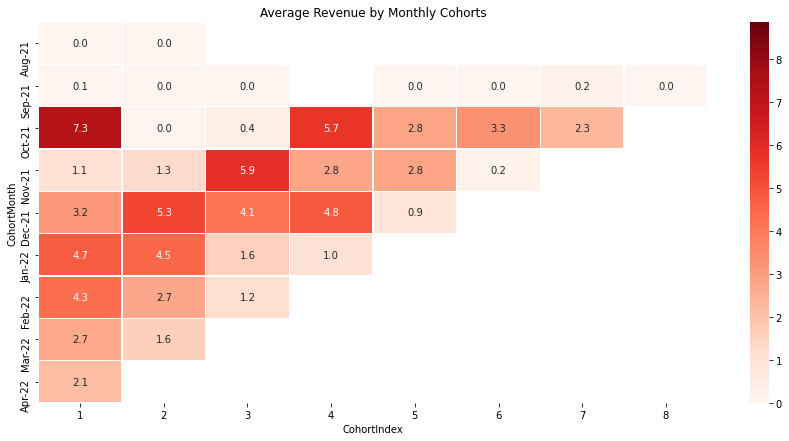

In [44]:
# PLOT HEATMAP

plt.figure(figsize=(15,7))
plt.title('Average Revenue by Monthly Cohorts')
# Create the heatmap
sns.heatmap(data=t_avg_rev,
annot = True,
cmap = "Reds",
vmin = 0.0,
vmax = list(t_avg_rev.max().sort_values(ascending = False))[1]+3,
fmt = '.1f',
linewidth = 0.3,
yticklabels=t_month_list)
plt.show()

**Explicación**: En este caso, el heatmap demuestra el revenue obtenido en promedio por los usuarios de cada cohorte y la evolución del mismo con el transcurso de los meses (en términos absolutos, no relativos).
- Las transacciones realizadas por el primer y segundo cohorte practicamente no generaron revenue.
- Esta métrica trajo mejoras a partir del cohorte iniciado en Octubre 2021, donde el revenue por cohorte ascendió al rango de 2.3 y 7.3 en promedio.
- Al igual que ocurrió con la retención, los mejores registros se encuentran en los meses de noviembre, diciembre y enero.

### RESPUESTA PUNTO 3) - LIFETIME VALUE (LTV)

Comienzo calculando el churn rate, que basicamente es el complemento de la tasa de retención para sumar 1. El primer mes de los cohortes siempre será equivalente al ARPU, si bien en los meses posteriores comience a verse el impacto del churning en el LTV

In [45]:
# CALCULATE CHURN RATE 

churn = ((t_retention - 100) * -1)/100
churn.round(1)

CohortIndex,1,2,3,4,5,6,7,8
CohortMonth,,,,,,,,
2021-08-01,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01,-0.0,0.5,0.5,NaN,0.5,0.5,0.5,0.5
2021-10-01,-0.0,0.9,0.7,0.4,0.7,0.7,0.7,NaN
2021-11-01,-0.0,0.5,0.5,0.7,0.5,0.7,NaN,NaN
2021-12-01,-0.0,0.1,0.3,0.5,0.7,NaN,NaN,NaN
2022-01-01,-0.0,0.3,0.5,0.7,NaN,NaN,NaN,NaN
2022-02-01,-0.0,0.3,0.7,NaN,NaN,NaN,NaN,NaN
2022-03-01,-0.0,0.6,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# CALCULATE LIFETIME VALUE PER USER

ltv = t_avg_rev.divide(churn, axis=0)
ltv[1] = t_avg_rev[1]

In [47]:
ltv

CohortIndex,1,2,3,4,5,6,7,8
CohortMonth,,,,,,,,
2021-08-01,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01,0.065160,0.000000,0.000000,NaN,0.000000,0.000000,0.389498,0.0
2021-10-01,7.259488,0.000000,0.542356,13.341418,3.978478,4.665038,3.287031,NaN
2021-11-01,1.082020,2.323677,10.879556,4.338747,6.151535,0.274216,NaN,NaN
2021-12-01,3.183123,58.174209,12.355348,10.610074,1.331394,NaN,NaN,NaN
2022-01-01,4.747841,16.754421,3.293107,1.506746,NaN,NaN,NaN,NaN
2022-02-01,4.317280,9.764649,1.848952,NaN,NaN,NaN,NaN,NaN
2022-03-01,2.717796,2.881093,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,2.148292,NaN,NaN,NaN,NaN,NaN,NaN,NaN


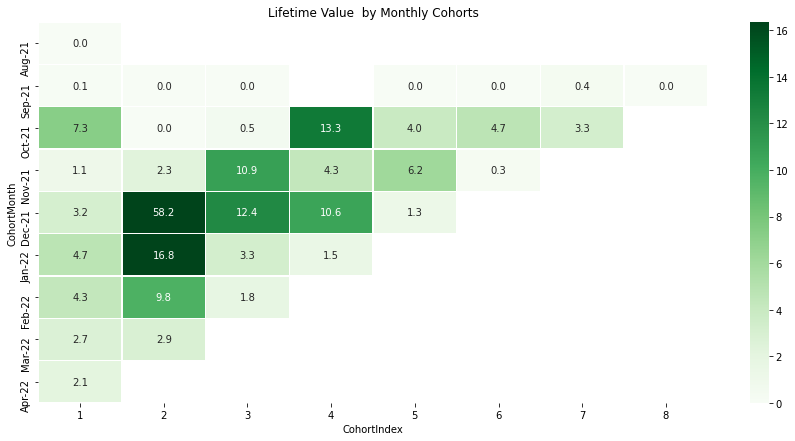

In [48]:
# CREATE HEATMAP OF LIFETIME VALUE

plt.figure(figsize=(15,7))
plt.title('Lifetime Value  by Monthly Cohorts')

sns.heatmap(data=ltv,
annot = True,
cmap = "Greens",
vmin = 0.0,
vmax = list(ltv.max().sort_values(ascending = False))[1]+3,
fmt = '.1f',
linewidth = 0.3,
yticklabels=t_month_list)
plt.show()

**Explicación**: El heatmap del LTV demuestra un comportamiento irregular en los cohortes iniciales, pero se estabiliza luego de  diciembre en el rango de 1-3 USD de valor por usuario para el negocio, lógicamente en línea con los mejores números de retención. 